**线形神经网络**

@ Follow: "动手学深度学习-第三章 线性神经网络"

In [2]:
import time
import random
import torch
from d2l import torch as d2l

---
# 小实验: 向量化带来的速度提升

In [3]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        return sum(self.times) / len(self.times)
    def sum(self):
        return sum(self.times)

In [13]:
# 方法1: 使用for循环
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'for loop:{timer.stop():.5f} sec')

# 方法2: 使用向量化
timer.start()
d = a + b
print(f'vectorization:{timer.stop():.5f} sec')

for loop:0.07114 sec
vectorization:0.00007 sec


---
# 线性回归-从0开始
- 线性模型满足线性假设
- 线性假设: 预测目标可以表示为输入特征的线性求和, 并加上一个偏置
- 数学形式: $ \hat{y} = Xw + b$
- 线性回归的目标: 找到一组权重向量$w$和偏置b(统称为模型参数)
- Mean Squared Error(MSE): 均方误差
    - 形式: $l(i) = \frac{1}{2} (\hat{y}^{(i)} - y^{(i)})^2$
    - 如果噪声服从正态分布, 优化MSE等价于优化最大似然(-log[likelihood])
- 取-log的原因: 使得优化是朝着最小值方向
- 线性模型是最简单的神经网络
- 由于模型重点发生在计算的地方, 计算神经网络的层数时, 不包括输入层

## 生成模拟数据集

In [14]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.5351, 0.7632]) 
label: tensor([2.6701])


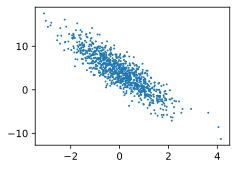

In [15]:
# 观察到特征和标签之间的线性关系
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

## 小批量读取数据

In [16]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [25]:
batch_size = 9
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-2.2340,  1.1457],
        [-0.6117, -0.6564],
        [-0.4884, -0.0757],
        [ 0.0767,  0.7131],
        [ 0.0083, -1.5726],
        [-0.6744, -0.4571],
        [ 0.7605, -0.1249],
        [-0.9557, -0.1469],
        [ 0.6730,  1.9212]]) 
 tensor([[-4.1718],
        [ 5.2152],
        [ 3.4803],
        [ 1.9196],
        [ 9.5785],
        [ 4.4192],
        [ 6.1418],
        [ 2.8014],
        [-0.9804]])


## 定义模型、损失函数、优化算法

In [27]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    """均方误差"""
    return 0.5 *(y_hat - y.reshape(y_hat.shape))**2

def sgd(params, lr, batch_size):
    """
    Minibatch stochastic gradient descent.

    :params: A list of parameters to optimize.
    :lr: The learning rate.
    :batch_size: The number of examples in each minibatch.
    """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练模型

In [28]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 超参数
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.017700
epoch 2, loss 0.000072
epoch 3, loss 0.000051


## 模型评估

In [29]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([1.0490e-05, 1.1873e-04], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0002], grad_fn=<RsubBackward1>)


---
# 线形回归-简洁实现

## 生成数据集

In [33]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [50]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# 打印第一个小批量样本
next(iter(data_iter))

[tensor([[-1.0710e+00,  6.6576e-01],
         [ 2.4319e-01,  3.9605e-04],
         [ 1.1750e+00, -1.7458e-01],
         [ 1.2006e+00,  1.1883e+00],
         [-1.6455e-01,  3.4487e-01],
         [-8.0327e-01, -8.0833e-01],
         [ 1.1168e+00, -1.4724e+00],
         [ 3.8462e-01,  2.6317e-01],
         [-3.6616e-01,  8.4918e-01],
         [ 4.8482e-01, -1.8836e-01]]),
 tensor([[-0.2154],
         [ 4.6889],
         [ 7.1422],
         [ 2.5822],
         [ 2.6986],
         [ 5.3444],
         [11.4420],
         [ 4.0710],
         [ 0.5811],
         [ 5.8142]])]

## 定义模型

In [57]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## 定义损失函数

In [58]:
loss = nn.MSELoss()

## 定义优化算法

In [60]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 训练模型

In [106]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000091
epoch 2, loss 0.000091
epoch 3, loss 0.000091


## 读取结果

In [108]:
w = net[0].weight.data
print('w的估计误差:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差:', true_b - b)

w的估计误差: tensor([ 0.0001, -0.0006])
b的估计误差: tensor([-0.0002])


---
# softmax回归